# Sentiment Analysis

## Business Understanding

In today’s hyper-connected digital landscape, consumer sentiment expressed on social media—particularly on platforms like Twitter—serves as a real-time barometer of brand perception, product satisfaction, and emerging issues. Apple and Google, as two of the world’s most influential technology companies, continuously launch new hardware (e.g., iPhones, Pixel phones, MacBooks) and software (e.g., iOS, Android, Google Assistant). Public reactions to these releases can significantly impact stock prices, customer retention, marketing strategy, and even product roadmap decisions.  


However, manually monitoring thousands of tweets daily is impractical. Organizations need **automated, scalable tools** to detect sentiment trends, identify dissatisfied users early, and amplify positive feedback—enabling proactive customer engagement and strategic decision-making.  


### Business Problem  
Brand and product teams at Apple, Google, or third-party agencies lack an efficient, automated system to:  
- Monitor real-time public sentiment about their products on Twitter.  
- Distinguish between positive advocacy, neutral commentary, and negative complaints.  
- Prioritize urgent issues (e.g., widespread bugs or PR crises) from noise.  

Without such a system, companies risk:  
- Missing early signals of product failures.  
- Failing to engage with brand advocates.  
- Reacting too slowly to viral negative sentiment.  

### Business Goals  
1. **Improve customer experience** by identifying and addressing pain points faster.  
2. **Enhance brand reputation management** through timely responses to negative sentiment.  
3. **Inform product development** by analyzing recurring themes in user feedback.  
4. **Support marketing teams** with insights into what features or campaigns resonate positively.  
5. **Reduce manual monitoring costs** by automating sentiment classification at scale.  


## Data Understanding

## 2. Data Understanding  

### Data Source  
The dataset originates from **CrowdFlower (now Figure Eight)**, made publicly available via **data.world**. It contains over **9,000 English-language tweets** manually annotated by human raters for sentiment.  

- **Key Columns**:  
  - `text`: The raw tweet content.  
  - `sentiment`: Label assigned by human annotators — typically **Positive**, **Negative**, or **Neutral/Neither**.  
  - (Optional) `keyword` or `topic`: May indicate product category (e.g., “iphone”, “android”).  

### Data Characteristics  
- **Volume**: ~9,000 labeled tweets — sufficient for a proof-of-concept model.  
- **Label Distribution**: Often imbalanced, with **Neutral** being the most frequent class, followed by **Positive**, then **Negative** (common in real-world sentiment data).  
- **Content Style**:  
  - Short, informal language.  
  - Heavy use of emojis, hashtags (#iPhone15), mentions (@AppleSupport), URLs, and slang.  
  - Mixed sentiment (e.g., “Love my Pixel but battery sucks”).  
- **Domain Relevance**: Not all tweets are about Apple or Google; filtering is required to isolate relevant product discussions.  


### Data Limitations  
- **Historical bias**: Data may reflect sentiment from a specific time period (e.g., around a product launch), limiting generalizability.  
- **Annotation subjectivity**: Sentiment is inherently subjective; inter-annotator agreement may vary.  
- **No metadata**: Lacks user demographics, location, or engagement metrics (likes, retweets), which could enrich analysis.  
- **Language scope**: English-only; not representative of global user base.  

Despite these limitations, the dataset provides a **high-quality, human-labeled foundation** for training a baseline sentiment classifier.  


## Project Objectives


### Primary Objective (Proof of Concept)  
> **Develop a machine learning model that automatically classifies the sentiment of Twitter posts about Apple and Google products into three categories: Positive, Negative, or Neutral—with performance suitable for internal business intelligence use.**  

### Specific, Measurable Goals  

| Objective | Success Metric |
|--------|----------------|
| **1. Build a functional binary classifier** (Positive vs. Negative) | ≥ 80% F1-score on test set |
| **2. Extend to a robust multiclass classifier** (3 classes) | ≥ 70% macro F1-score; clear separation of Negative class |
| **3. Prioritize recall for Negative sentiment** | ≥ 75% recall for Negative class (to minimize missed complaints) |
| **4. Deliver an interactive demo** | Streamlit app deployed and usable by non-technical stakeholders |
| **5. Ensure model interpretability** | Ability to inspect top predictive words (via TF-IDF weights) |

### Iterative Approach  
- **Phase 1**: Binary classification (simpler evaluation, faster iteration).  
- **Phase 2**: Multiclass extension with business-aligned evaluation (e.g., cost-sensitive metrics).  
- **Phase 3**: Integration into a dashboard or alerting system (future scope).  


### Expected Business Impact  
- **Faster issue detection**: Reduce time-to-response for product complaints from days to minutes.  
- **Data-driven decisions**: Product teams receive quantified feedback on feature reception.  
- **Scalability**: Foundation for analyzing millions of tweets in near real-time (with cloud infrastructure).  
- **Competitive insight**: Compare sentiment trends between Apple and Google products over time.  

---

## Future Opportunities (Beyond PoC)  

- **Aspect-based sentiment analysis**: Identify sentiment toward specific features (e.g., “battery”, “camera”, “OS update”).  
- **Real-time streaming**: Integrate with Twitter API to monitor live sentiment.  
- **Multilingual support**: Expand to Spanish, Hindi, etc., for global markets.  
- **Integration with CRM**: Auto-create support tickets for highly negative tweets.  
- **Trend visualization**: Dashboard showing sentiment over time by product line.  


### importing libraries

In [16]:
#!pip install pandas scikit-learn nltk joblib matplotlib seaborn

import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score
)
from sklearn.pipeline import Pipeline
import joblib
import warnings
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
warnings.filterwarnings("ignore")

# Download stopwords
nltk.download('stopwords', quiet=True)
STOP_WORDS = set(stopwords.words('english'))



### Loading data

In [ ]:
# Update this path if needed
FILEPATH = "judge-1377884607_tweet_product_company.csv"  # or use URL if hosted

# Load data
df = pd.read_csv(FILEPATH, encoding='latin1')
print(f"Loaded {len(df)} rows.")

# Inspect first few rows



Loaded 9093 rows.


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [7]:
display(df.head(20))


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion


In [4]:
df.columns


Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directed_at_a_brand_or_product'],
      dtype='object')

In [5]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64

In [6]:
df['emotion_in_tweet_is_directed_at'].value_counts()

emotion_in_tweet_is_directed_at
iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: count, dtype: int64

Since our main focus is to check the tweet we will remove the null values

In [9]:
df = df.dropna(subset=['tweet_text'])


<Figure size 1200x800 with 0 Axes>

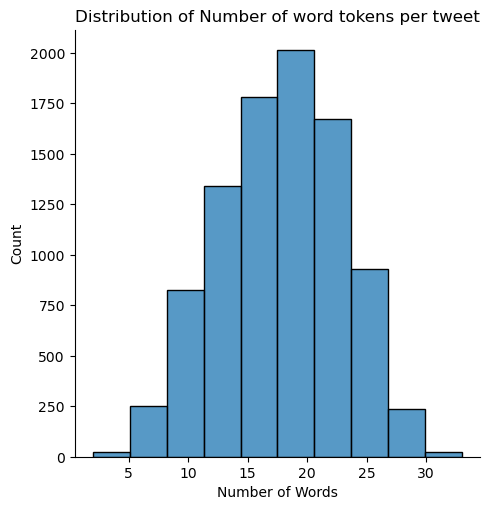

In [12]:
num_words_per_tweet = df['tweet_text'].apply(
    lambda text: len(text.split())
)

plt.figure(figsize=(12,8))
sns.displot(num_words_per_tweet, bins=10)
plt.xlabel("Number of Words")
plt.title("Distribution of Number of word tokens per tweet")
plt.show()

In [31]:
df['is_there_an_emotion_directed_at_a_brand_or_product'] = df['is_there_an_emotion_directed_at_a_brand_or_product'].replace('No emotion toward brand or product', 'Neutral emotion')

In [ ]:
# Normalize sentiment labels
df['sentiment'] = df['sentiment'].astype(str).str.strip().str.capitalize()
df['sentiment'] = df['sentiment'].replace({'Neither': 'Neutral'})

# Keep only standard classes
df = df[df['sentiment'].isin(['Positive', 'Negative', 'Neutral'])].copy()

# Filter for Apple/Google mentions
apple_google_keywords = [
    'apple', 'iphone', 'ipad', 'mac', 'ios', 'siri', 'macbook',
    'google', 'android', 'pixel', 'chrome', 'gmail', 'search', 'nexus'
]
pattern = r'\b(?:' + '|'.join(apple_google_keywords) + r')\b'
df['mentions_tech'] = df['text'].str.contains(pattern, case=False, na=False)
df = df[df['mentions_tech']].copy()
df.drop(columns=['mentions_tech'], inplace=True)

print(f"\nAfter filtering: {len(df)} Apple/Google-related tweets.")
print("\nSentiment distribution:")
print(df['sentiment'].value_counts())

# Plot distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='sentiment', order=['Positive', 'Neutral', 'Negative'])
plt.title("Sentiment Class Distribution")
plt.show()

### Text preporocessing

In [20]:
def clean_tweet(text):
    """Clean tweet text for modeling."""
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # URLs
    text = re.sub(r'@\w+', '', text)  # Mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags (optional)
    text = re.sub(r'[^a-z\s]', ' ', text)  # Keep letters and spaces
    text = ' '.join(text.split())  # Normalize whitespace
    return text

df['tweet_text'] = df['tweet_text'].apply(clean_tweet)

print("\nCleaned tweet:\n", df['tweet_text'].iloc[0])
# Test cleaning



Cleaned tweet:
 i have a g iphone after hrs tweeting at it was dead i need to upgrade plugin stations at


In [21]:
# tokenization of benefitsReview column
df['tweet_text_tokenized'] = df['tweet_text'].apply(lambda x: word_tokenize(x))
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,tweet_text_tokenized
0,i have a g iphone after hrs tweeting at it was...,iPhone,Negative emotion,"[i, have, a, g, iphone, after, hrs, tweeting, ..."
1,know about awesome ipad iphone app that you ll...,iPad or iPhone App,Positive emotion,"[know, about, awesome, ipad, iphone, app, that..."
2,can not wait for also they should sale them do...,iPad,Positive emotion,"[can, not, wait, for, also, they, should, sale..."
3,i hope this year s festival isn t as crashy as...,iPad or iPhone App,Negative emotion,"[i, hope, this, year, s, festival, isn, t, as,..."
4,great stuff on fri marissa mayer google tim o ...,Google,Positive emotion,"[great, stuff, on, fri, marissa, mayer, google..."


In [22]:
# remove non words: numbers, symbols
df['tweet_text_tokenized'] = df['tweet_text_tokenized'].apply(lambda x: [word for word in x if word.isalpha()])
# removal of stop words
df['tweet_text_tokenized'] = df['tweet_text_tokenized'].apply(lambda x: [word.lower() for word in x if word.lower() not in stopwords.words()])
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,tweet_text_tokenized
0,i have a g iphone after hrs tweeting at it was...,iPhone,Negative emotion,"[g, iphone, hrs, tweeting, dead, upgrade, plug..."
1,know about awesome ipad iphone app that you ll...,iPad or iPhone App,Positive emotion,"[awesome, ipad, iphone, app, appreciate, desig..."
2,can not wait for also they should sale them do...,iPad,Positive emotion,[wait]
3,i hope this year s festival isn t as crashy as...,iPad or iPhone App,Negative emotion,"[hope, year, festival, crashy, year, iphone, app]"
4,great stuff on fri marissa mayer google tim o ...,Google,Positive emotion,"[great, stuff, fri, marissa, mayer, google, ti..."


In [23]:
df['tweet_text_tokenized_str'] = df['tweet_text_tokenized'].apply(lambda x: " ".join(x))
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,tweet_text_tokenized,tweet_text_tokenized_str
0,i have a g iphone after hrs tweeting at it was...,iPhone,Negative emotion,"[g, iphone, hrs, tweeting, dead, upgrade, plug...",g iphone hrs tweeting dead upgrade plugin stat...
1,know about awesome ipad iphone app that you ll...,iPad or iPhone App,Positive emotion,"[awesome, ipad, iphone, app, appreciate, desig...",awesome ipad iphone app appreciate design givi...
2,can not wait for also they should sale them do...,iPad,Positive emotion,[wait],wait
3,i hope this year s festival isn t as crashy as...,iPad or iPhone App,Negative emotion,"[hope, year, festival, crashy, year, iphone, app]",hope year festival crashy year iphone app
4,great stuff on fri marissa mayer google tim o ...,Google,Positive emotion,"[great, stuff, fri, marissa, mayer, google, ti...",great stuff fri marissa mayer google tim reill...


Bag of words

In [24]:
# Create a bag of words: Unigrams
reviews_complete = " ".join(df['tweet_text_tokenized_str'])
count_vectorizer = CountVectorizer(lowercase=True, ngram_range=(1, 1), stop_words="english")
sparse_matrix = count_vectorizer.fit_transform([reviews_complete])
counts_df = pd.DataFrame(sparse_matrix.toarray(),columns=count_vectorizer.get_feature_names_out())
counts_df = counts_df.T
counts_df.reset_index(inplace=True)
counts_df.columns = ['word','count']
# sort by frequency descending orde
counts_df.sort_values(by='count',ascending=False,inplace=True)
# filter to return only num_top rows
counts_df = counts_df.iloc[:10,:]
print(counts_df)

        word  count
3882    link   4313
5727      rt   2970
3495    ipad   2440
2848  google   2342
277    apple   1918
5313    quot   1696
6420   store   1485
3501  iphone   1325
400   austin    861
208      amp    836


In [25]:
# Create a bag of words: Bigrams
reviews_complete = " ".join(df['tweet_text_tokenized_str'])
count_vectorizer = CountVectorizer(lowercase=True, ngram_range=(2, 2), stop_words="english")
sparse_matrix = count_vectorizer.fit_transform([reviews_complete])
counts_df = pd.DataFrame(sparse_matrix.toarray(),columns=count_vectorizer.get_feature_names_out())
counts_df = counts_df.T
counts_df.reset_index(inplace=True)
counts_df.columns = ['word','count']
# sort by frequency descending orde
counts_df.sort_values(by='count',ascending=False,inplace=True)
# filter to return only num_top rows
counts_df = counts_df.iloc[:10,:]
print(counts_df)

                 word  count
17543         link rt   1011
1767      apple store    556
27518  social network    452
25408       rt google    345
22474       pop store    341
11287   google launch    329
20218  network called    326
30475      today link    312
4363   called circles    303
18588    major social    291


### Word cloud

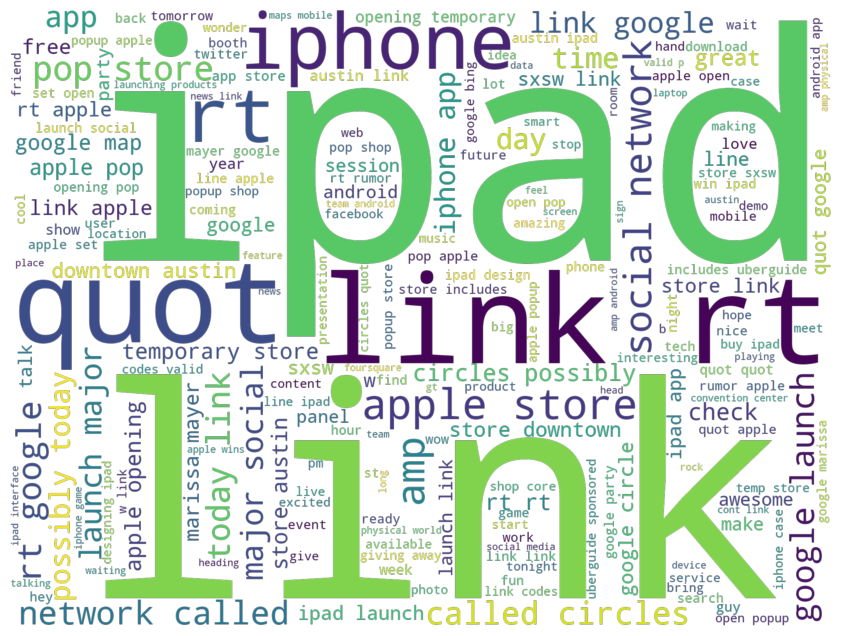

In [26]:
# visualize a wordcloud of benefitsReview column
#reviews_corpus = " ".join()

plt.figure(figsize=(12,8))
wordcloud = WordCloud(
    width=2000,
    height=1500,
    #stopwords=stop_words,
    background_color=None,
    mode='RGBA'
).generate_from_text(reviews_complete)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Vader

In [29]:
# perform sentiment analysis using Vader/Textblob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

analyzer = SentimentIntensityAnalyzer()

df['vader_polarity'] = df['tweet_text_tokenized_str'].map(
    lambda text: analyzer.polarity_scores(text)['compound']
)
df['vader_sentiment'] = df['vader_polarity'].apply(
    lambda score: 'Positive' if score>=0 else 'Negative'
)
df.head(20)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,tweet_text_tokenized,tweet_text_tokenized_str,vader_polarity,vader_sentiment
0,i have a g iphone after hrs tweeting at it was...,iPhone,Negative emotion,"[g, iphone, hrs, tweeting, dead, upgrade, plug...",g iphone hrs tweeting dead upgrade plugin stat...,-0.6486,Negative
1,know about awesome ipad iphone app that you ll...,iPad or iPhone App,Positive emotion,"[awesome, ipad, iphone, app, appreciate, desig...",awesome ipad iphone app appreciate design givi...,0.9100,Positive
2,can not wait for also they should sale them do...,iPad,Positive emotion,[wait],wait,0.0000,Positive
3,i hope this year s festival isn t as crashy as...,iPad or iPhone App,Negative emotion,"[hope, year, festival, crashy, year, iphone, app]",hope year festival crashy year iphone app,0.7269,Positive
4,great stuff on fri marissa mayer google tim o ...,Google,Positive emotion,"[great, stuff, fri, marissa, mayer, google, ti...",great stuff fri marissa mayer google tim reill...,0.6249,Positive
5,new ipad apps for and communication are showca...,NaN,No emotion toward brand or product,"[ipad, apps, communication, showcased, confere...",ipad apps communication showcased conference,0.0000,Positive
7,is just starting is around the corner and is o...,Android,Positive emotion,"[starting, corner, hop, skip, jump, time]",starting corner hop skip jump time,0.0000,Positive
8,beautifully smart and simple idea rt wrote abo...,iPad or iPhone App,Positive emotion,"[beautifully, smart, simple, idea, rt, wrote, ...",beautifully smart simple idea rt wrote ipad app,0.7506,Positive
9,counting down the days to plus strong canadian...,Apple,Positive emotion,"[counting, days, strong, canadian, dollar, mea...",counting days strong canadian dollar means sto...,0.5106,Positive
10,excited to meet the at so i can show them my s...,Android,Positive emotion,"[excited, meet, show, sprint, galaxy, running,...",excited meet show sprint galaxy running android,0.3400,Positive


## Vader visual

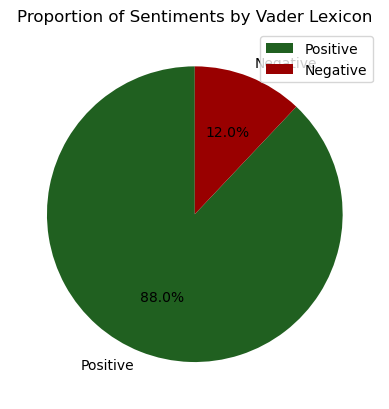

In [30]:
fig, ax = plt.subplots()
colors = ("#206020","#990000")
sentiment_props = df['vader_sentiment'].value_counts()
ax.pie(sentiment_props.values, colors=colors, labels=sentiment_props.index, autopct="%1.1f%%", startangle=90)
plt.title("Proportion of Sentiments by Vader Lexicon")
plt.legend(loc='upper right')
plt.show()

### Binary classification (Positive and Negative)

In [ ]:
# Filter out Neutral
df_bin = df[df['sentiment'] != 'Neutral'].copy()
df_bin['label'] = df_bin['sentiment'].map({'Positive': 1, 'Negative': 0})

X = [clean_tweet(t) for t in df_bin['text']]
y = df_bin['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Build pipeline
binary_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=10000,
        ngram_range=(1, 2),
        stop_words='english'
    )),
    ('clf', LogisticRegression(random_state=42, max_iter=1000))
])

# Train
print("🚀 Training binary classifier...")
binary_pipe.fit(X_train, y_train)

# Predict & evaluate
y_pred = binary_pipe.predict(X_test)
print("\n📊 Binary Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"F1 (macro): {f1_score(y_test, y_pred, average='macro'):.3f}")

### Multi class classification additional neutral class

In [ ]:
# Prepare 3-class data
label_map = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
df['label'] = df['sentiment'].map(label_map)

X = [clean_tweet(t) for t in df['text']]
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Build multiclass pipeline
multi_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=10000,
        ngram_range=(1, 2),
        stop_words='english'
    )),
    ('clf', LogisticRegression(random_state=42, max_iter=1000, multi_class='ovr'))
])

# Train
print("🚀 Training multiclass classifier...")
multi_pipe.fit(X_train, y_train)

# Predict & evaluate
y_pred = multi_pipe.predict(X_test)
print("\n📊 Multiclass Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"F1 (macro): {f1_score(y_test, y_pred, average='macro'):.3f}")

# Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Confusion Matrix (Multiclass)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

### Modelling

In [ ]:
# Save models
joblib.dump(multi_pipe, "sentiment_model_multiclass.pkl")
joblib.dump(binary_pipe, "sentiment_model_binary.pkl")
print("💾 Models saved!")

# Prediction helper
def predict_sentiment(tweet, model=multi_pipe, mode='multiclass'):
    cleaned = clean_tweet(tweet)
    pred = model.predict([cleaned])[0]
    if mode == 'binary':
        return 'Positive' if pred == 1 else 'Negative'
    else:
        label_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
        return label_map.get(pred, 'Unknown')

# Test on custom tweets
test_tweets = [
    "I absolutely love my new MacBook Pro!",
    "Google Photos deleted all my memories. Worst update ever.",
    "Just bought a new charger. Works fine.",
    "iPhone battery life is terrible this year 😠"
]

print("🔍 Prediction Demo (Multiclass):")
for t in test_tweets:
    sentiment = predict_sentiment(t)
    print(f"Tweet: {t}")
    print(f"→ Sentiment: {sentiment}\n")

### Evaluation

In [ ]:
# Example: What if we care most about catching NEGATIVE tweets?
# Compute recall for Negative class in multiclass setting
from sklearn.metrics import recall_score

# Get predictions again
y_pred = multi_pipe.predict(X_test)

# Extract true and predicted for Negative (class 0)
negative_recall = recall_score(y_test, y_pred, labels=[0], average=None)[0]
print(f"❗ Recall for Negative tweets (multiclass): {negative_recall:.3f}")
print("→ This tells us how often we correctly flag complaints.")